In [1167]:
import pandas as pd
import matplotlib as plt
import pyarrow as pa
import matplotlib.pyplot as plt
import os
import glob

In [1168]:
import os
import glob
import pandas as pd

# Ruta base de las carpetas de estados
ruta_base = "estados"

# Obtener todas las carpetas dentro de la ruta base
carpetas = sorted(os.listdir(ruta_base))

# Leer el nombre de la última carpeta procesada de un archivo de estado
archivo_estado = "review-Alabama"
if os.path.exists(archivo_estado):
    with open(archivo_estado, "r") as f:
        ultima_carpeta = f.read().strip()
    # Encontrar el índice de la siguiente carpeta
    indice_ultima = carpetas.index(ultima_carpeta) if ultima_carpeta in carpetas else -1
else:
    indice_ultima = -1

# Obtener la siguiente carpeta
if indice_ultima + 1 < len(carpetas):
    nombre_carpeta = carpetas[indice_ultima + 1]
    print(f"Procesando la carpeta: {nombre_carpeta}")
else:
    print("Todas las carpetas han sido procesadas.")
    nombre_carpeta = None

if nombre_carpeta:
    # Guardar el nombre de la carpeta actual en el archivo de estado
    with open(archivo_estado, "w") as f:
        f.write(nombre_carpeta)

    # Crear la ruta completa de la carpeta actual
    ruta_completa = os.path.join(ruta_base, nombre_carpeta)

    # Cargar todos los archivos JSON en una lista de DataFrames
    dataframes = []
    for filename in sorted(glob.glob(os.path.join(ruta_completa, "*.json"))):
        df = pd.read_json(filename, dtype={'user_id': str}, lines=True)
        dataframes.append(df)

    # Concatenar todos los DataFrames en uno solo
    df = pd.concat(dataframes, ignore_index=True)
    print("Data unida exitosamente.")
else:
    print("No hay carpetas nuevas para procesar.")


Todas las carpetas han sido procesadas.
No hay carpetas nuevas para procesar.


In [1169]:
#Verificar cuántas filas y columnas tiene.
df.shape

(15624, 6)

In [1170]:
#Revisar el tipo de cada columna (numérica, categórica, etc.).
df.dtypes

user_id            object
name               object
time       datetime64[ns]
rating              int64
text               object
gmap_id            object
dtype: object

In [1171]:
#Observar las primeras filas para obtener una visión general del contenido.
df.head()

,user_id,name,time,rating,text,gmap_id
27,116215367992334944994,Fred Hopkin,2019-02-09 22:28:49,5,Who would think to find good food in Burlingto...,0x534bf3c523ffc94f:0xa8546be3a972f1fb
28,104055366526496553308,Layne Nichols,2019-01-09 16:48:33,5,Really neat restaurant. Very good food and fri...,0x534bf3c523ffc94f:0xa8546be3a972f1fb
29,105213428884394941723,Albert Henderson,2018-06-23 01:48:34,5,Excellent food and service!! Will be going again.,0x534bf3c523ffc94f:0xa8546be3a972f1fb
30,104512928985768167605,Fonda Williams,2018-08-26 03:51:26,5,Excellent food and very nice people!,0x534bf3c523ffc94f:0xa8546be3a972f1fb
31,108952332114683033789,Llama Wrangler,2019-05-31 21:01:36,4,They are closing the operation at this locatio...,0x534bf3c523ffc94f:0xa8546be3a972f1fb


**TRATAMIENTO DE NULOS**

In [1172]:
df.isnull().sum()

user_id    0
name       0
time       0
rating     0
text       0
gmap_id    0
dtype: int64

In [1173]:
#Al ver las columnas me di cuenta que las columnas de pics y resp son innecesarias y por eso vamos a eliminarlas
df = df.drop('pics', axis=1)
df = df.drop('resp', axis=1)

KeyError: "['pics'] not found in axis"

In [ ]:
#Tambien podemos observar que gran parte de las reviews son sin texto por eso vamos a proceder a reemplazar los nulos por un string de "NaN"
df['text'].fillna('NaN', inplace=True)

C:\Users\joaqu\AppData\Local\Temp\ipykernel_8768\2317022110.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text'].fillna('NaN', inplace=True)


In [ ]:
#Revisamos una vez mas por si acaso
df.isnull().sum()


user_id    0
name       0
time       0
rating     0
text       0
gmap_id    0
dtype: int64

**ELIMINACION DE NEGOCIOS QUE NO SEAN RESTAURANTES MEDIANTE "GMAP_ID"**

In [ ]:
df_clasificador = pd.read_json('../metadata_sitios/gmap_id_restaurantes.json', typ='series')

In [ ]:
df = df[df['gmap_id'].isin(df_clasificador)]

*TIPOS DE DATOS*


In [ ]:
df.dtypes

user_id    object
name       object
time        int64
rating      int64
text       object
gmap_id    object
dtype: object

In [ ]:
#Cambiar la columna de time que esta en modo UNIX a tipo fecha sin los milisegundos
df['time'] = pd.to_datetime(df['time'], unit='ms')  # Conviertes el tiempo de Unix (en milisegundos)
df['time'] = df['time'].dt.floor('s')  # Redondear a segundos

In [ ]:
df['name'] = df['name'].astype(str)

In [ ]:
df.dtypes

user_id            object
name               object
time       datetime64[ns]
rating              int64
text               object
gmap_id            object
dtype: object

**TRATAMIENTO DE DUPLICADOS**

In [ ]:
df.drop_duplicates(inplace=True)

**ESTADISTICA**

In [ ]:
#Use .describe() para ver metricas como mean, standard deviation, min, max, and quartiles.
df.describe()

,time,rating
count,15747,15747.000000
mean,2019-04-04 03:36:52.822505984,4.218518
min,2011-03-25 03:41:43,1.000000
25%,2018-06-24 04:09:16.500000,4.000000
50%,2019-04-27 05:18:04,5.000000
75%,2020-01-23 03:41:10,5.000000
max,2021-08-19 01:08:26,5.000000
std,NaN,1.076317


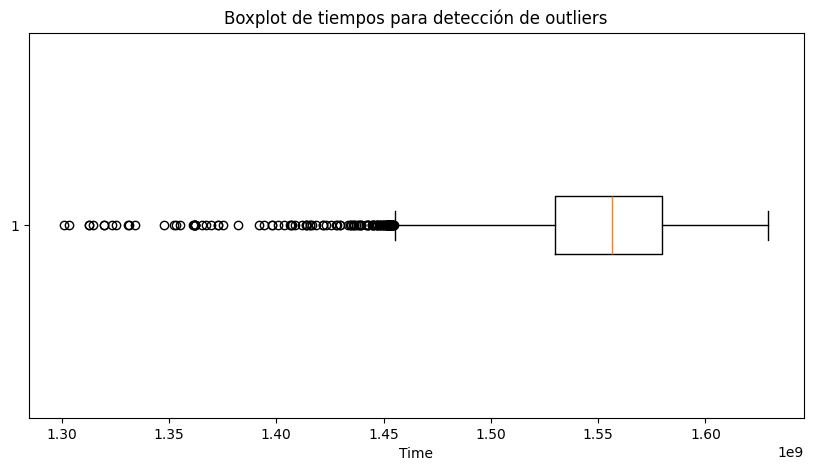

In [ ]:
#Vamos a detectar Outliers
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(df['time'].astype('int64') // 10**9, vert=False)
plt.title("Boxplot de tiempos para detección de outliers")
plt.xlabel("Time")
plt.show()


In [ ]:
#Eliminacion de valores atipicos

# Obtener cuartiles e IQR para calcular los límites
Q1 = df['time'].quantile(0.25)
Q3 = df['time'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers (1.5 veces el IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame eliminando los outliers
df = df[(df['time'] >= lower_bound) & (df['time'] <= upper_bound)]


In [ ]:
#Use .value_counts() para examinar la frecuencia en diferentes categorias.A
df['rating'].value_counts()

rating
5    8495
4    4060
3    1798
1     677
2     594
Name: count, dtype: int64

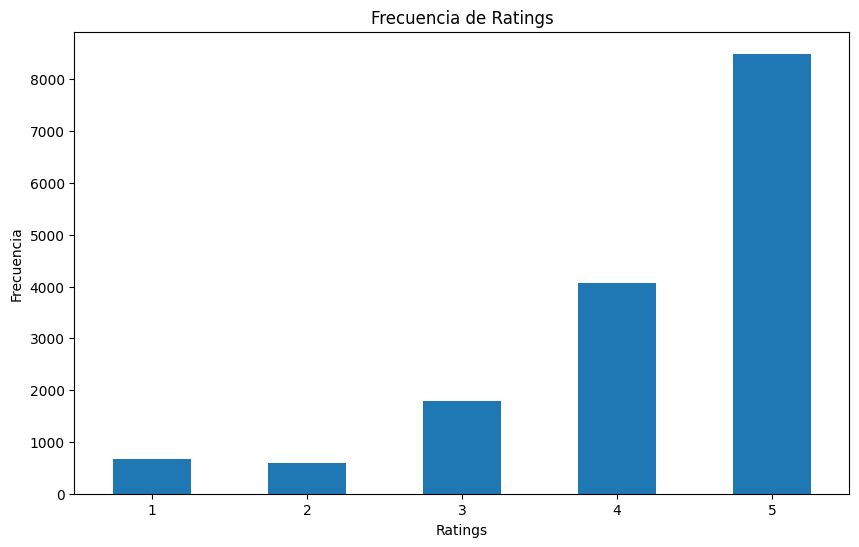

In [ ]:
plt.figure(figsize=(10, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Frecuencia de Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()


In [ ]:
df.to_json(f'estados_limpios/{nombre_carpeta}_limpio.json', orient='records', lines = True)